# CSX46 Class Session 8: Betweenness Centrality

Objective: implement betweenness centrality based on Newman's algorithm (Sec.&nbsp;10.3.6), with normalization using the same normalization method used by the igraph betweenness centrality method.
Test it out on some small undirected graphs. Compare to the results obtained using the method `igraph.Graph.betweenness`.

For this notebook, we will need the python packages `cairo`, `collections`, `random`, `pprint`, and `igraph`.

In [2]:

import cairo

import collections, random, igraph, pprint

Let's use type hints (see [PEP 484](https://www.python.org/dev/peps/pep-0484/)) to annotate the types of the arguments for the two functions that we will write in this notebook. To do that, we will need to import `List` and `Tuple` from `typing`. This is one case where I tend to use a "relative import", so as to not clutter function signatures throughout the code-base:

In [3]:
from typing import List, Tuple

We are going to set the state of the Python pseudo-random number generator (PRNG) using a seed value `1337`, using `random.seed`. This will help ensure that everyone's randomly generated Barabasi-Albert graph looks the same.

In [4]:
random.seed(1337)

Generate a 10-vertex Barabási-Albert graph and assign it to variable `g`. Draw the graph, with vertex labels.

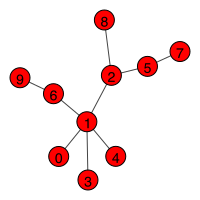

In [5]:
g = igraph.Graph.Barabasi(10)
igraph.drawing.plot(g, bbox=[0, 0, 200, 200], vertex_label=list(range(0, 10)))

Get an adjacency list representation of the graph `g`, using the `igraph.Graph.get_adjlist` method, and assign it to variable `g_adjlist`. Print the adjacency list (see if you can print it in the format showen below, using `pprint.pprint` and `enumerate`, without having to use dictionary comprehension).
```
{0: [1],
 1: [0, 2, 3, 4, 6],
 2: [1, 5, 8],
 3: [1],
 ....}
```

In [ ]:
g_adjlist = g.get_adjlist()
pprint.pprint(dict(enumerate(g_adjlist)))

{0: [1],
 1: [0, 2, 3, 4, 6],
 2: [1, 5, 8],
 3: [1],
 4: [1],
 5: [2, 7],
 6: [1, 9],
 7: [5],
 8: [2],
 9: [6]}


First, we are going to write a function `single_vertex_bfs_with_paths_and_weights` which will execute a breadth-first search (BFS) of an undirected simple graph from a single starting vertex (specified as the argument `s`) to all other vertices in the same component as `s`, and return a list with four components:
- `dist` containing geodesic distances to all vertices from `s`
- `paths` containing the next-hop backpath edges to get back to `s` (along the geodesic path) from any vertex
- `weights` the number of distinct geodesic paths back to `s` from each vertex
- `orders` is an ordering of the vertices so that `dist` values are nonincreasing

Let's try to include type hints in the function definition (it's a good habit, even in python where type hints are not checked at runtime by the CPython interpreter). Your function `single_vertex_bfs_with_paths_and_weights` should take two arguments:
- `s`: type `int` (the ID of the vertex at which we will start the breadth-first search)
- `g`: type `List[List[int]]` (the graph, in adjacency list representation)

In [ ]:
def single_vertex_bfs_with_paths_and_weights(s: int, g: List[List[int]]) -> \
Tuple[List[int], List[List[int]], List[int], List[int]]:
    # Let's review the function arguments:
    # `s` is the index of the vertex that we are at (type `int`)
    # `g` is the graph in adjacency list format (type `List[List[int]]`)

    # get the integer number of vertices in the graph (length of the list `g`)
    # and assign to `N`
    N = len(g)

    # define a `list` of length `N` containing the integer value -1,
    # [-1, -1, ... -1]; use the * operator; assign it to variable `dists`
    dists = [-1]*N

    # we know the distance (0) from vertex "s" to "s" (as the ending vertex);
    # so, set that entry in the `dists` list to value zero
    dists[s] = 0

    # define a `list` of length `N` containing the integer value 0,
    # [0, 0, ..., 0]; use the * operator; assign it to variable `weights`
    weights = [0]*N

    # we'll say that there is a single path from s to itself, so set the `s`
    # entry of `weights` to integer value 1
    weights[s] = 1

    # define a `list` of N empty lists, to contain the next-hop backpath edges to
    # get back to `s` from each vertex; assign it to the variable `paths`
    paths = [[] for i in range(N)]

    # create an empty `collections.deque` object and assign it to the variable
    # `work`
    work = collections.deque()

    # add the vertex `s` to the queue `work`, using the `collections.deque.append`
    # method
    work.append(s)

    # create an empty `list` to contain the vertex IDs in decreasing order of
    # the vertices' geodesic distances from `s`; assign to the variable `orders`
    orders = []

    # start a `while` loop that will run until `work` has zero length
    while work:
        # grab the next vertex in the `work` queue using the `popleft` method,
        # and assign it to the variable `u`
        u = work.popleft()

        # since `u` is an integer vertex ID, use it to index into the adjacency
        # list `g` to get the list of vertex IDs of neighbors of `u`; assign that
        # list to variable `u_neighbors`
        u_neighbors = g[u]

        # iterate over `u_neighbors`, each time assigning the element to `v`
        for v in u_neighbors:
            # branch on whether list `dists` at position `v` is negative
            # (meaning that we have not visited vertex `v` before)
            if dists[v] < 0:  # we haven't visited this vertex before
                # compute dists[u]+1 and set dists[v] to this value
                dists[v] = dists[u] + 1

                # set weights[v] to the value weights[u]
                weights[v] = weights[u]

                # add `v` to the queue `work` using the `append` method
                work.append(v)

                # add item `v` to the *end* of the `orders` list (build up orders
                # in the reverse of the orientation we want, then *later* we will
                # reverse it before returning it in the final tuple return value)
                orders.append(v)

                # construct a list with `u` appended to `paths[v]`, and
                # store that list in `paths[v]`
                paths[v] += [u]
            else:             # we have visited this vertex before
                # check if there is already a path of length `dists[u] + 1`
                if dists[v] == dists[u] + 1:
                    # construct a list with `u` appended to `paths[v]`, and
                    # store that list in `paths[v]`
                    paths[v] += [u]

                    # increment `weights[v]` by `weights[u]`
                    weights[v] += weights[u]

    # return a tuple of `dists`, `paths`, `weights`, `orders[::-1]`;
    # the [::-1] slice syntax reverses a list
    return (dists, paths, weights, orders[::-1])

Let's test your function `single_vertex_bfs_with_paths_and_weights`. Run it on vertex 0 of `g_adjlist`, and print the results. Do they make sense, given the definitions of the four entries in the expected return tuple from the function?

In [ ]:
single_vertex_bfs_with_paths_and_weights(0, g_adjlist)

([0, 1, 2, 2, 2, 3, 2, 4, 3, 3],
 [[], [0], [1], [1], [1], [2], [1], [5], [2], [6]],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [7, 9, 8, 5, 6, 4, 3, 2, 1])

Now, define an `igraph.Graph` object for a slightly more complex graph as shown below (assign it to variable `tg`)

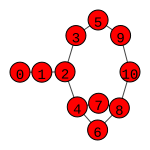

In [ ]:
tg = igraph.Graph.TupleList([[0, 1],
                             [1, 2],
                             [2, 3],
                             [2, 4],
                             [3, 5],
                             [4, 6],
                             [4, 7],
                             [6, 8],
                             [5, 9],
                             [7, 8],
                             [8, 10],
                             [9, 10]])
igraph.drawing.plot(tg, bbox=[0, 0, 150, 150], vertex_label=range(0, 11))

Get the adjacency list for this graph, using the `igraph.Graph.get_adjlist` method, and assign it to `tg_adjlist`. Print out the adjacency list. Does it make sense?

In [ ]:
tg_adjlist = tg.get_adjlist()
print(tg_adjlist)

[[1], [0, 2], [1, 3, 4], [2, 5], [2, 6, 7], [3, 9], [4, 8], [4, 8], [6, 7, 10], [5, 10], [8, 9]]


What do you expect to be the outcome of running `single_vertex_bfs_with_paths_and_weights` for vertex 0?  What will be the weight for vertex 10?  

In [ ]:
single_vertex_bfs_with_paths_and_weights(0, tg_adjlist)

([0, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6],
 [[], [0], [1], [2], [2], [3], [4], [4], [6, 7], [5], [9, 8]],
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3],
 [10, 8, 9, 7, 6, 5, 4, 3, 2, 1])

Thinking question: why should the weight value for vertex 10 in the above call to `single_vertex_bfs_with_paths_and_weights` be 3?

Now we will define a function `all_vertices_betweenness_centrality` that will compute Newman-style betweenness centrality (with igraph-style normalization) for each vertex in an undirected simple graph.

In [ ]:
def all_vertices_betweenness_centrality(g: List[List[int]]) -> List[float]:
    # compute the number of vertices as the `len` of list `g` and assign to `N`
    N = len(g)

    # define a list [0., 0., ..., 0.] of length `N`, and assign to `final_scores`
    final_scores = [0.]*N

    # for `s` in 0, ..., N-1: (this is pseudocode)
    for s in range(N):
        # call `single_vertex_bfs_with_paths_and_weights` with `s`, `g`;
        # assign the return tuple to (dists, paths, weights, orders)
        (dists, paths, weights, orders) = single_vertex_bfs_with_paths_and_weights(s, g)

        # define a list [1., 1., ..., 1.] of length `N`, and assign to `scores`
        scores = [1.]*N

        # iterate over `orders`, assigning each element to `v`:
        for v in orders:

            # get the list element at `paths[v]` and assign to `neighbors`
            neighbors = paths[v]

            # iterate over each item in `neighbors`, and assign to `neighbor`:
            for neighbor in neighbors:
                # compute the ratio `weights[neighbor]` to `weights[v]` and
                # assign it to the variable `ratio`
                ratio = weights[neighbor]/weights[v]

                # increment `scores[neighbor]` by `scores[v]*ratio`
                scores[neighbor] += scores[v]*ratio

        # iterate over `range(N)` and assign each to variable `u`:
        for u in range(N):
            # increment `final_scores[u]` by `scores[u]`
            final_scores[u] += scores[u]

    # iterate over `range(N)` and assign each element to variable `s`:
    for s in range(N):
        # compute (final_scores[s] - 2*N + 1)/2.0 and assign to `final_scores[s]`
        final_scores[s] = (final_scores[s] - 2*N + 1)/2.0

    # return `final_scores`
    return final_scores

Call `all_vertices_betweenness_centrality` on `g_adjlist` and print the results

In [ ]:
all_vertices_betweenness_centrality(g_adjlist)

[0.0, 29.0, 20.0, 0.0, 0.0, 8.0, 8.0, 0.0, 0.0, 0.0]

On the graph `g`, run the `igraph.Graph.betweenness` method, with `directed=False`, and print the resulting list. Compare to what you got from running `all_vertices_betweenness_centrality`. Do they match?

In [ ]:
g.betweenness(directed=False)

[0.0, 29.0, 20.0, 0.0, 0.0, 8.0, 8.0, 0.0, 0.0, 0.0]